# Isomap

---

## Exercise 1

- Write your own implementation of Isomap.

- Apply it to the Swiss Roll dataset ($n = 1000$) from Lab 1.

- Use a modified version of the Swiss Roll dataset, in which Gaussian noise from a Normal $N(\mu = 0, \sigma = 0.5)$ is added to the $x$ and $y$ coordinates. Apply Isomap to this dataset and discuss the differences with the previous point.

In [50]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's start by generating our Swiss Roll datasets with $n = 1000$.

In [51]:
# SWISS ROLL (standard)

# Sampling
n = 1000
phi = np.random.uniform(1.5*np.pi, 4.5*np.pi, n)
psi = np.random.uniform(0, 10, n)

# Coordinates
x = phi*np.cos(phi)
y = phi*np.sin(phi)
z = psi

# Create a dataframe from the coordinates
data = {
    'x': x,
    'y': y,
    'z': z
}
X = pd.DataFrame(data)
X

,x,y,z
0,0.722539,-11.037320,1.844581
1,11.513565,6.159451,1.344959
2,-1.236637,7.912960,4.120456
3,11.033667,-5.055522,4.658424
4,11.102935,-4.930502,7.963702
...,...,...,...
995,4.789286,5.262606,2.489091
996,-2.496221,-10.467970,5.169356
997,-8.592097,2.972409,4.226740
998,0.692129,-11.036524,8.153467


In [52]:
# SWISS ROLL (noisy)

# Sampling
n = 1000
phi = np.random.uniform(1.5*np.pi, 4.5*np.pi, n)
psi = np.random.uniform(0, 10, n)

# Noise
noise_x = np.random.normal(0, 0.5, n)
noise_y = np.random.normal(0, 0.5, n)

# Coordinates
x = phi * np.cos(phi) + noise_x
y = phi * np.sin(phi) + noise_y
z = psi

# Create a dataframe from the coordinates
data = {
    'x': x,
    'y': y,
    'z': z
}
X_noisy = pd.DataFrame(data)
X_noisy

,x,y,z
0,3.107655,5.635421,7.311390
1,11.165218,6.023257,2.873615
2,-7.659018,-8.559616,1.632722
3,12.631691,-3.916130,8.647727
4,6.445423,2.803852,5.352461
...,...,...,...
995,10.757744,7.388801,4.289079
996,11.348660,7.257666,8.251149
997,4.087801,-4.057653,6.534980
998,4.062498,5.374141,9.514403


We must also define the algorithm we will use to compute the minimum path between nodes in the graph: Dijkstra.

In [53]:
def dijkstra(g, source):
    dist = {v: np.inf for v in g.nodes}
    dist[source] = 0
    visited = set()
    queue = set(g.nodes)

    while queue:
        u = min((v for v in queue), key=lambda v: dist[v])
        queue.remove(u)
        visited.add(u)

        for neighbor, attr in g[u].items():
            if neighbor in queue:
                alt = dist[u] + attr['distance']
                if alt < dist[neighbor]:
                    dist[neighbor] = alt
    return dist

Now we can code our Isomap function.

#TODO isomap expl

In [54]:
def distance_matrix(g):
    nodes = list(g.nodes)
    delta = np.zeros((len(nodes), len(nodes)))

    for i, source in enumerate(nodes):
        dist_dict = dijkstra(g, source)
        
        for j in range(i, len(nodes)):
            target = nodes[j]
            
            if target in dist_dict:
                delta[i, j] = dist_dict[target]
                delta[j, i] = dist_dict[target]
            else:
                delta[i, j] = np.inf
                delta[j, i] = np.inf

    return delta


def isomap(x, n_neighbors=5):
    
    # Nearest Neighbors
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(x)
    neigh_dist, neigh_idx = neigh.kneighbors()
    
    # Graph
    g = nx.Graph()
    for index, col in x.iterrows():
        g.add_node(index, x=col['x'], y=col['y'], z=col['z'])
        for i in range(len(neigh_idx[index])):
            g.add_edge(index, neigh_idx[index][i], distance=neigh_dist[index][i])
    
    # Distance matrix (by Dijkstra)
    delta = distance_matrix(g)

    return delta

delta = isomap(X, 5)
delta_noisy = isomap(X_noisy, 5)

c:\Users\carlo\Desktop\Unsupervised-Learning\venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
c:\Users\carlo\Desktop\Unsupervised-Learning\venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


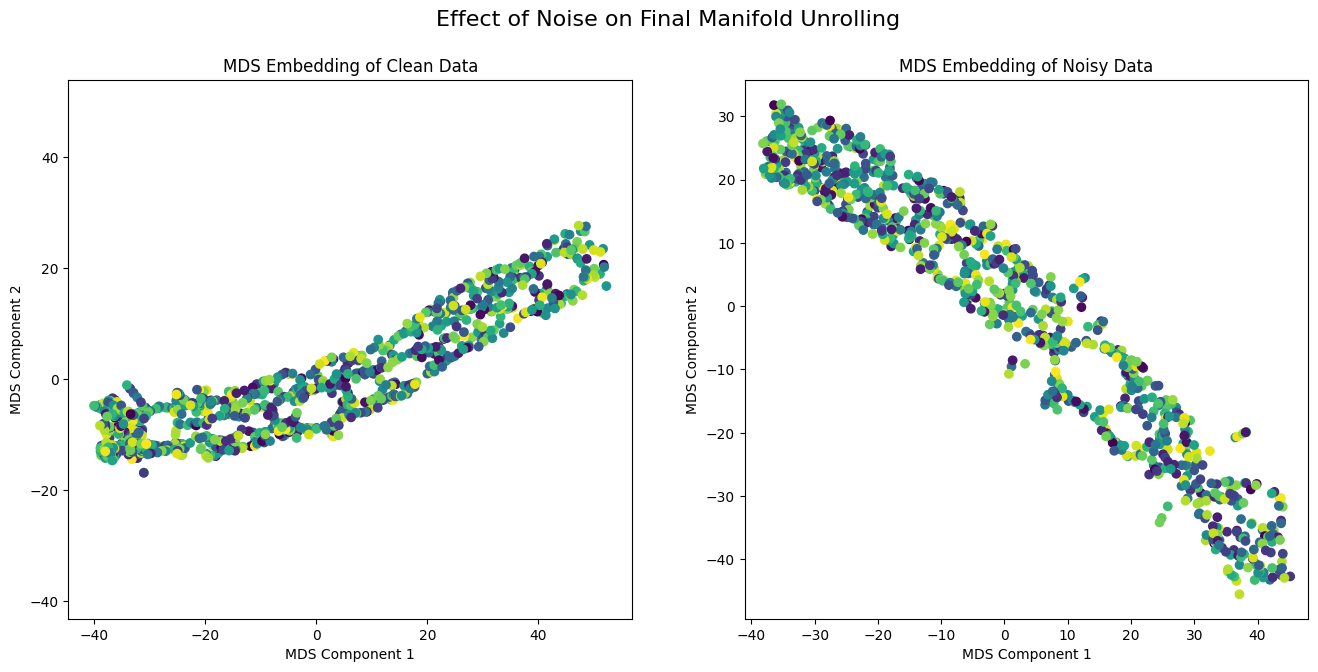

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress=False)

# Unroll the clean data
embedding = mds.fit_transform(delta)

# Unroll the noisy data
embedding_noisy = mds.fit_transform(delta_noisy)

# Visualize the results side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot clean embedding
axes[0].scatter(embedding[:, 0], embedding[:, 1], c=phi, cmap='viridis')
axes[0].set_title('MDS Embedding of Clean Data')
axes[0].set_xlabel('MDS Component 1')
axes[0].set_ylabel('MDS Component 2')
axes[0].axis('equal')

# Plot noisy embedding
axes[1].scatter(embedding_noisy[:, 0], embedding_noisy[:, 1], c=phi, cmap='viridis')
axes[1].set_title('MDS Embedding of Noisy Data')
axes[1].set_xlabel('MDS Component 1')
axes[1].set_ylabel('MDS Component 2')
axes[1].axis('equal')

plt.suptitle('Effect of Noise on Final Manifold Unrolling', fontsize=16)
plt.show()

---
# Exercise 2 

Undersample randomly from the `Dry Bean Dataset` in order to have $n = 1000$ datapoints. Follow the same pipeline of Exercise 1 of the previous lab by replacing PCA with Isomap. Discuss the differences with particular focus on the accuracy of the logistic regression.

Important note: in this case, you don’t need to do the train-test split. Apply ISOMAP to the whole dataset first, and then do the train-test split and follow the rest of the pipeline.